# Reflections on the Pinball Loss Function in Quantile Regression

*Published October 05, 2024*

I was just beginning to delve into the paradigm of conformal prediction when I came across an example in the [tutorial by 
Angelopoulos and Bates](https://arxiv.org/abs/2107.07511) that dealt with quantile regression. This gave me reason to think more carefully about different types of regression and objective functions, independently of the context of conformal prediction methods. In the following, I will present a few of these considerations.

Sometimes when we do machine learning and turn to black box models like neural networks, we run the risk of forgetting the implications of choosing one loss function over another. A well-known example of a loss function is a quadratic loss of the form $(a - Y)^2$, where $a$ denotes a number, which typically approximates the other quantity $Y$. We use a capital letter for $Y$ to indicate that this is a random variable, i.e. an object that can take different realizations based on an underlying distribution that is typically not known (otherwise we would not have to do statistical inference). Of course, with $Y$, $(a-Y)^2$ itself is a random variable that we can study, for example by looking at the expected value $E\left[(a-Y)^2\right]$. We can differentiate this expectation with respect to $a$, set this expression to zero and solve for $a$ to see that $a^{*} = E\left[Y\right]$ is a stationary point of the function. Due to the shape of the function, it is also easy to see that $a^{*}$ is even a local minimum. The $a$ that minimizes the expected squared deviation of $Y$ is, not surprisingly, the expected value of the random variable $Y$.

Instead of a single random variable, we could also have the case where $Y$ depends on a covariate $X$. This case corresponds to the typical machine learning setting, where we write the conditional expectation of $Y$ given $X$ as a parametric function of $X$. That is, we assume that $E\left[Y \mid X\right] = a(X; \vartheta^{*})$ holds in the population for a fixed parameter (or parameter vector) $\vartheta^{*}$. The optimization problem $\min_{\vartheta} E\left[ (a(X; \vartheta) - Y)^2 \mid X\right]$ is then solved under the assumptions made, in accordance with the unconditional example, by the conditional expectations, that is, if $\vartheta = \vartheta^{*}$ applies. Since the transition from the conditioned to the unconditioned case is always straightforward, we will only deal with unconditional probabilities in the following.

With this preface, let us return to the quantile regression and the question of how the choice of the objective function influences which estimand we elevate to the subject of the analysis. A simple modification of our quadratic objective function could be to replace the quadratic distance by the absolute distance. What do we expect to get when we solve the resulting optimization problem? Without calculating, we anticipate the answer, since, as we shall see, this is a special case of quantile regression. The $a$ that minimizes $E[\left\vert a - Y \right\vert ]$ is the median of the distribution of $Y$, i.e., the $0.5$ quantile. A $\gamma$-quantile $t_{\gamma}$ is mathematically defined by the property $P(Y \le t_{\gamma}) = \gamma$. It should be noted that for CDFs that are not strictly monotonically increasing, care must be taken when deciding which value to consider as the actual quantile. In the following, for the sake of simplicity, we assume that $Y$ has a strictly monotonically increasing CDF $F_Y$.

Without further ado, I now introduce the loss function that is used for the purpose of generalized $\gamma$-quantile regression. It reads
$$
L_{\gamma}(t, Y) = \begin{cases}
(Y - t) \gamma & \text{if}\quad Y > t \\
(t - Y) (1 - \gamma) & \text{else.}
\end{cases}
$$
The first thing we notice is that for $\gamma = 0.5$ we get back just $(1/2)\left\vert t - Y\right\vert$, i.e. our absolute distance from before, multiplied by a constant that is irrelevant from an optimization point of view. We also notice that we can write $L_{\gamma}$ more compactly using indicator functions according to
$$
L_{\gamma}(t, Y) = (Y-t) \, \gamma \, \mathbf{1}\left[ Y > t\right] + (t - Y) \, (1 - \gamma) \, \mathbf{1}\left[ Y \le t \right]\text{.}
$$
As before, we consider $L_{\gamma}$ in expectation. That is, we form the expectation with respect to $F_Y$ on the left and right and get
$$
E\left[ L_{\gamma}(t, Y) \right] = \gamma \, \left\{ E \left[ Y \mathbf{1}\left[ Y > t\right] \right] - t \, P\left( Y > t\right) \right\}
+ (1 - \gamma) \, \left\{ t \, P\left( Y \le t\right) - E \left[ Y \mathbf{1}\left[ Y \le t\right] \right]\right\}\text{.}
$$

This looks a bit intimidating, but overall it is quite straightforward to read. Indicator variables appear in the expected values, which we can understand as restrictions of the integration range of $Y$ to only those values that are greater than $t$ in the first case and not greater in the second case. From Chebyshev's inequality, we see directly that the two differences are each positive, i.e. the loss does not take on any negative values.

**Interlude** (Simulation with normally distributed $Y$). This is not a Jupyter notebook for no reason. We want to simulate $L_{\gamma}(t, Y)$. To do this, we repeatedly draw realizations of $Y_1, \dots, Y_n$, here from a standard normal distribution, and then plot the resulting curves over a sufficiently large interval $(t_0, t_1)$ (the support of the normal distribution actually extends from -$\infty$ to $\infty$).

In [2]:
from typing import Dict

import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

from sklearn.utils import Bunch

In [3]:
def simulate_quantile_loss(sample_size: int, gamma: float = 0.5) -> Dict[str, np.ndarray]:
    
    ys = scipy.stats.norm.rvs(size=sample_size)
    ts = np.linspace(-3, 3, 501)

    # loss_values: (num grid points, sample size)
    mask = ys.reshape(1, -1) > ts.reshape(-1, 1)
    loss_values = (
        gamma * (ys.reshape(1, -1) - ts.reshape(-1, 1)) * mask
        + (1 - gamma) * (ts.reshape(-1, 1) - ys.reshape(1, -1)) * (1 - mask)
    )
    
    return Bunch(
        loss=loss_values,
        ts=ts
    )

In [4]:
np.random.seed(42)
res = simulate_quantile_loss(sample_size=256)

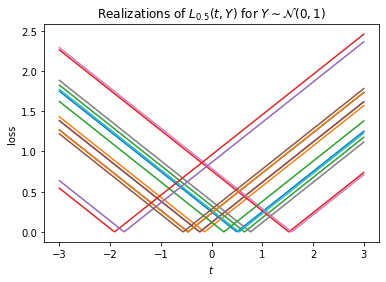

In [9]:
fig, ax = plt.subplots()
for loss in res.loss.T[:16]:
    ax.plot(res.ts, loss)
ax.set_xlabel("$t$")
ax.set_ylabel("loss")
ax.set_title("Realizations of $L_{0.5}(t, Y)$ for $Y \sim \mathcal{N}(0, 1)$")
plt.show()

The plot shows 16 different realizations of $L_{\gamma = 0.5}$. Of course, the true $0.5$ quantile for a standard normal distribution is $0$. We can determine the empirical mean of the loss values for each of the grid points and also display it.

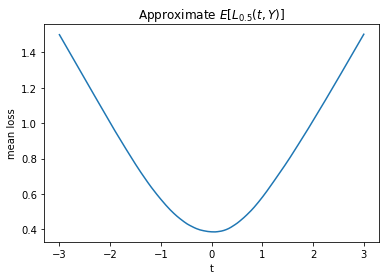

In [11]:
mean_loss = res.loss.mean(axis=-1)
fig, ax = plt.subplots()
ax.plot(res.ts, mean_loss)
ax.set_xlabel("t")
ax.set_ylabel("mean loss")
ax.set_title("Approximate $E[L_{0.5}(t, Y)]$")
plt.show()

In expectation, the *jagged* curves of the loss (also called a *pinball loss* for obvious reasons) become a smooth curve. As can be seen, the minimum is actually assumed at $t=0$, as expected. $\square$

The simulation suggests that the loss (in expectation) is minimal when $t$ coincides with the theoretical $\gamma$-quantile $t_{\gamma}$. This can be verified. We recall that we assumed the CDF of $Y$ to be monotonically increasing. This means that every $t$ effectively corresponds to some $t_{\lambda}$ with $\lambda \in (0,1)$. It is very useful to write the expectation as a function of $\lambda$ and then to demonstrate that this has a local minimum when $\lambda$ coincides with $\gamma$. That is precisely what we shall do. It is
$$
E\left[ L_{\gamma}(t_{\lambda}, Y) \right] = \gamma \, \left\{ E \left[ Y \mathbf{1}\left[ Y > t_{\lambda}\right] \right] - t_{\lambda} \, (1 - \lambda) \right\}
+ (1 - \gamma) \, \left\{ t_{\lambda} \, \lambda - E \left[ Y \mathbf{1}\left[ Y \le t_{\lambda}\right] \right]\right\}\text{,}
$$
where we have made use of the definition of $t_{\lambda}$, i.e. $P(Y \le t_{\lambda}) = \lambda$.

In order to differentiate with respect to $\lambda$, we need to understand how this operation is compatible with the expectation operator. We will take the physicist's approach here and intuitively justify what the derivative should look like. If $Y$ is absolutely continuous, it has a density $f_Y$, we can write:
$$
\begin{align*}
E \left[ Y \mathbf{1}\left[ Y \le t_{\lambda + \mathrm{d}\lambda}\right]\right]
&= \int_{-\infty}^{t_{\lambda + \mathrm{d}\lambda}} y \, f_Y(y) \, \mathrm{d}y \\
&= \int_{-\infty}^{t_{\lambda}} y \, f_Y(y) \, \mathrm{d}y + \int_{t_{\lambda}}^{t_{\lambda + \mathrm{d}\lambda}} y \, f_Y(y) \, \mathrm{d}y \\
&\simeq E \left[ Y \mathbf{1}\left[ Y \le t_{\lambda}\right]\right] + t_{\lambda} \, \mathrm{d}\lambda\text{,}
\end{align*}
$$
whereby the last approximation follows from the definition of the quantiles and the probability measure itself.

This makes it easy to determine the derivative of the expected value of the loss with respect to $\lambda$. We find that
$$
\begin{align*}
\frac{\mathrm{d}}{\mathrm{d}\lambda} E\left[ L_{\gamma}(t_{\lambda}, Y) \right] = \left\{ (1 - \gamma) \, \lambda - \gamma \, (1 - \lambda) \right\} \, \frac{\mathrm{dt_{\lambda}}}{\mathrm{d}\lambda}\text{.}
\end{align*}
$$
And this expression vanishes exactly when $\lambda = \gamma$ is fulfilled, given that $\mathrm{d} t_{\lambda} / \mathrm{d} \lambda \neq 0$. What kind of object is this? This is easy to determine. To do that, we just have to differentiate the equation $\lambda = P(Y \le t_{\lambda})$ with respect to $\lambda$. We then get that
$$
\frac{\mathrm{dt_{\lambda}}}{\mathrm{d}\lambda} = \left( \left. \frac{\mathrm{dF_Y}}{\mathrm{d}y} \right\vert_{y=t_{\lambda}} \right)^{-1} = 1 / f_Y(t_{\lambda})\text{.}
$$

This quantity is certainly a positive number. This is a practical result, because it allows us to verify that the found stationary point $\lambda^{*} = \gamma$ is indeed a local minimum. To do this, it is sufficient to show that the second derivative of the expected value, interpreted as a function of $\lambda$, is positive at the presumed optimum. We see that
$$
\frac{\mathrm{d^2}}{\mathrm{d}\lambda^2} E\left[ L_{\gamma}(t_{\lambda}, Y) \right] = \frac{\mathrm{dt_{\lambda}}}{\mathrm{d}\lambda} + \frac{\mathrm{d^2t_{\lambda}}}{\mathrm{d}\lambda^2} \left\{ (1 - \gamma) \, \lambda - \gamma \, (1 - \lambda) \right\}\
$$
But the second term disappears when $\lambda = \gamma$ applies, making the expression identical to $\mathrm{d} t_{\lambda} / \mathrm{d} \lambda \vert_{\lambda=\gamma}$ and therefore greater than zero.

In summary, we have shown that the expected value of $L_{\gamma}$ is minimal when the value $t$ corresponds to $t_{\gamma}$. Applied to the conditioned case or machine learning applications, the objective function can thus be used to learn any quantile of the conditioned distribution of $Y\mid X$.

Note also that it is easy to consider several such losses simultaneously, for example, to learn not just a quantile, but a quantile range. Such ranges are interesting for quantifying the uncertainty of a prediction. If you also want to have a rigorous notion of unertainty (with coverage guaranteed by theory), quantile regression can be used as a basis for constructing prediction intervals using the methods of conformal prediction.